In [137]:
# Author: Matteo Serafino, 2023
#
# This notebook focuses on the analyses presented in Section two of the reference paper.
# 
# Before proceeding, make sure to run "section_two_*_utilities.py" which creates part
# of the necessary files for the analyses.



In [138]:
import pandas as pd
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects

import numpy as np

import graph_tool.all as gt
import glob



In [141]:
def print_results(clients, group,p_val,fdhr,thresh = 0.05, path = 'causal',test = 'pars_corr',plus = False):
    
    for path in glob.glob(f"/sdf/MatteoPaper/section_four/{path}/*"):

        if plus and 'plus' not in path:
            continue
        elif 'plus' in path:
            continue
        
        if test not in path:
            continue
            
        if clients not in path:
            continue

        if group not  in path:
            continue
        if 'max_comb5'  in path:
            continue
        if 'max_comb1'  in path:
            continue
            
        file = path.split('/')[-1][:-7]

        fdhr_treshold = file.split('fdrh_t')[-1]
        p_value = file.split('residuals_')[-1].split('_max_comb')[0]
        test = file.split('__')[1].split('_analytic')[0]
        pc_alpha = file.split('pc_alpha')[1].split('_tau')[0]
        group = file.split('residuals')[0].split('_')[-2]
        client = file.split('residuals')[0].split('_')[-3]
        
        if p_value != p_val:
            continue
        if fdhr_treshold != fdhr:
            continue
            
        res = pd.read_pickle(path)
        
        thresh = thresh


        print('fdhr_treshold = ', fdhr_treshold)
        print('p_value = ', p_value)
        print('test = ', test)
        print('pc_alpha = ', pc_alpha)
        print('group = ', group)
        print('client = ', client)
        print('treshold causal = ',thresh)
        print('\n')
        print(res['df_CEmax'])

        suffix = ''
        df_CEmax = res['df_CEmax']
        df_CEmax_mean = res['df_CEmax_mean']
        df_CEmax_std = res['df_CEmax_std']
        df_CEmax_tau = res['df_CEmax_tau']
        G = gt.Graph()


        # i -> j
        edge_list = []
        for j in df_CEmax.columns:
            for i in df_CEmax.index:
                if not np.isnan(df_CEmax.loc[j,i]):
                    edge_list.append((i,j, df_CEmax.loc[j,i], df_CEmax_mean.loc[j,i], 
                                           df_CEmax_std.loc[j,i], df_CEmax_tau.loc[j,i]))

        G.ep['CEmax'] = G.new_edge_property('float')
        G.ep['CEmax_mean'] = G.new_edge_property('float')
        G.ep['CEmax_std'] = G.new_edge_property('float')
        G.ep['CEmax_tau'] = G.new_edge_property('float')

        G.vp['var_names'] = G.add_edge_list(edge_list, hashed=True,
                                eprops=[G.ep['CEmax'], G.ep['CEmax_mean'],
                                        G.ep['CEmax_std'], G.ep['CEmax_tau']])

        name2v_id = dict((G.vp['var_names'][v], G.vertex_index[v]) for v in  G.vertices())
        print(name2v_id)
        gt.remove_self_loops(G)
        #%% prepare graph plot
        pos = G.new_vertex_property('vector<double>')

        #%% prepare graph plot
        if 'IandS' in path:
            supps =['IandS']# ['I','S']
        else:
            supps =['IRA']

        infls = ['WC' ,
                 'SC',
                 'WT',
                 'ST',
                 'U']


        #add= ['IRA','Suspended']

        num_infls = len(infls)
        infl_y_pos = np.linspace(-4, 4, len(infls))
        infl_x_pos = -2

        supp_y_pos = np.linspace(-2, 2, 2)
        supp_x_pos = 2

        #add_y_pos = np.linspace(-2, 4, 2)
        #add_x_pos = 4


        # set positions
        for name, ypos in zip(supps, supp_y_pos):
            pos[name2v_id[name]] = [supp_x_pos, ypos]

        for name, ypos in zip(infls, infl_y_pos):
            pos[name2v_id[name]] = [infl_x_pos, ypos]

        #for name, ypos in zip(add, add_y_pos):
        #    pos[name2v_id[name]] = [add_x_pos, ypos]


        x, y = pos[name2v_id['WT']]    
        pos[name2v_id['WT']] = x +3. , y 

        if 'ST' in name2v_id:
            x, y = pos[name2v_id['ST']]    
            pos[name2v_id['ST']] = x -2 , y -2


        x, y = pos[name2v_id['WC']]    
        pos[name2v_id['WC']] = x + 3, y+0.5

        x, y = pos[name2v_id['SC']]    
        pos[name2v_id['SC']] = x -2, y-1.5

        x, y = pos[name2v_id['U']]    
        pos[name2v_id['U']] = x+1.3 , y-5.7

        if 'IandS' in path:
            x, y = pos[name2v_id['IandS']]    
            pos[name2v_id['IandS']] = x-5 , y+0.3
        else:
            x, y = pos[name2v_id['IRA']]    
            pos[name2v_id['IRA']] = x-5 , y+0.3  
        # set node colors
        #from PlotUtils import mediacolors, trump_color, clinton_color, darker


        vfillcolor = G.new_vertex_property('vector<double>')

        from palettable.cartocolors.diverging import Geyser_7_r as colormap
        gray_color=[c/255 for c in [128, 128, 128]]
        yellow_color=[c/255 for c in [255,255,0]]
        orange_color=[c/255 for c in [255, 128, 0]]
        clinton_color = [c/255 for c in [0, 0, 255]]
        clinton_supp=[c/255 for c in [0, 150, 255]]
        trump_supp = [c/255 for c in [205,38,38]]
        trump_color = [c/255 for c in [139, 0, 0]]

        #ira_color=

        def darker(color, percent):
            '''assumes color is rgb between (0, 0, 0) and (1, 1, 1)'''
            color = np.array(color)
            black = np.array([0, 0, 0])
            vector = black-color
            return color + vector * percent

        vfillcolor = G.new_vertex_property('vector<double>')

        if 'IandS' in path:
            vfillcolor[name2v_id['IandS']] = orange_color
        else:
            vfillcolor[name2v_id['IRA']] = orange_color
            #vfillcolor[name2v_id['S']] = orange_color        
        vfillcolor[name2v_id['U']] = gray_color
        vfillcolor[name2v_id['WT']] = trump_supp
        vfillcolor[name2v_id['WC']] = clinton_supp
        vfillcolor[name2v_id['ST']] = trump_color
        vfillcolor[name2v_id['SC']] = darker(clinton_color,0.4)


        infl_ids = [name2v_id[name] for name in infls]
        supp_ids = [name2v_id[name] for name in supps]

        #vfillcolor[name2v_id['IRA']] = trump_color
        #vfillcolor[name2v_id['Suspended']] = trump_color


        edge_color = G.new_edge_property('vector<double>')

        alpha = 0.8

        for edge in G.edges():

            ecolor = vfillcolor[edge.source()].copy()
            #ecolor[3] = alpha
            edge_color[edge] = ecolor 

        # rescale edge width    
        max_width = 50
        min_width = 1
        ewidth = G.new_edge_property('double')
        ewidth.a = (G.ep.CEmax.a - G.ep.CEmax.a.min())/max(G.ep.CEmax.a - G.ep.CEmax.a.min())*(max_width-min_width)+\
                min_width

        vsize = G.new_vertex_property('float')

        # use autolinks for node size
        for name in df_CEmax.columns:
            vsize[name2v_id[name]] = df_CEmax.loc[name,name]

        max_vsize = 60
        min_vsize = 20

        vsize.a = (vsize.a - vsize.a.min())/(max((vsize.a - vsize.a.min())))*(max_vsize-min_vsize) +\
                  min_vsize

        #%% plot graph


        def thresh_edges(e, thresh=0.05):
            return G.ep.CEmax[e] > thresh



        Gfilt = gt.GraphView(G, efilt=lambda e:thresh_edges(e, thresh))
        names = Gfilt.new_vertex_property('string')
        for v in Gfilt.vertices():
            names[v] = Gfilt.vp.var_names[v]

        #graph_filename = 'figures/paper_figures/revisions/CE_graph_{condtest}_q0{q_0}_thresh{thresh}_max_comb{max_comb}_taumax{tau_max}_pc_alpha{pc_alpha}{suffix}.svg'.\
        #                      format(q_0=parameters['q_0'], thresh=thresh,
        #                             condtest=parameters['cond_ind_test'],
        #                             max_comb=parameters['max_combinations'],
        #                             tau_max=parameters['tau_max'],
        #                             pc_alpha=parameters['pc_alpha'],
        #                             suffix=suffix)
        #print(graph_filename)                   
        #if os.path.exists(graph_filename):
        #    graph_filename=None
        #    print('file exists, not saving')
        rename_dict = {'IRA':'IRA',
                       'S':'Suspended',
                       'WC': 'Weak Clinton supporters',
                       'WT': 'Weak Trump supporters',
                       'ST': 'Strong Trump supporters',
                       'SC': 'Strong Clinton supporters', 
                       'U': 'Undecided',
                       'IandS':'IRA + S'}          

        names = Gfilt.new_vertex_property('string')
        for v in Gfilt.vertices():
            names[v] = rename_dict[Gfilt.vp.var_names[v]]

        gt.graph_draw(Gfilt, pos=pos,edge_pen_width=ewidth,
                      vertex_halo=False,
                      vertex_size=vsize,
                      bg_color=[1,1,1,1], 
                      vertex_pen_width=0, 
                      vertex_fill_color=vfillcolor,
                      #vertex_text=names,
                      vertex_text_position=1,
                      vertex_text_color=[0,0,0,2],
        #             edge_marker_size=ewidth,
                      edge_color=edge_color,
                      vertex_font_family='Helvetica Neue LT Std',
                      #output='Causal.pdf'
                     )
        print('----------------------------------------------')
    return res

fdhr_treshold =  0.001
p_value =  5
test =  pars_corr
pc_alpha =  0.05
group =  IandS
client =  OfficialClient
treshold causal =  0.2


          IandS        WT        WC        ST        SC         U
IandS  0.383552  0.022495  0.049984  0.287383  0.199702  0.054808
WT     0.175257  0.509885  0.117984   0.04003  0.177852  0.085958
WC     0.244208  0.065621  0.785875  0.131979  0.143368  0.060944
ST     0.112951  0.015889  0.018159  0.483541  0.174676  0.052303
SC     0.202085  0.038589  0.085911  0.144399   0.77038  0.059373
U      0.174967  0.247321  0.352374  0.066589  0.139568  0.207437
{'IandS': 0, 'WT': 1, 'WC': 2, 'ST': 3, 'SC': 4, 'U': 5}


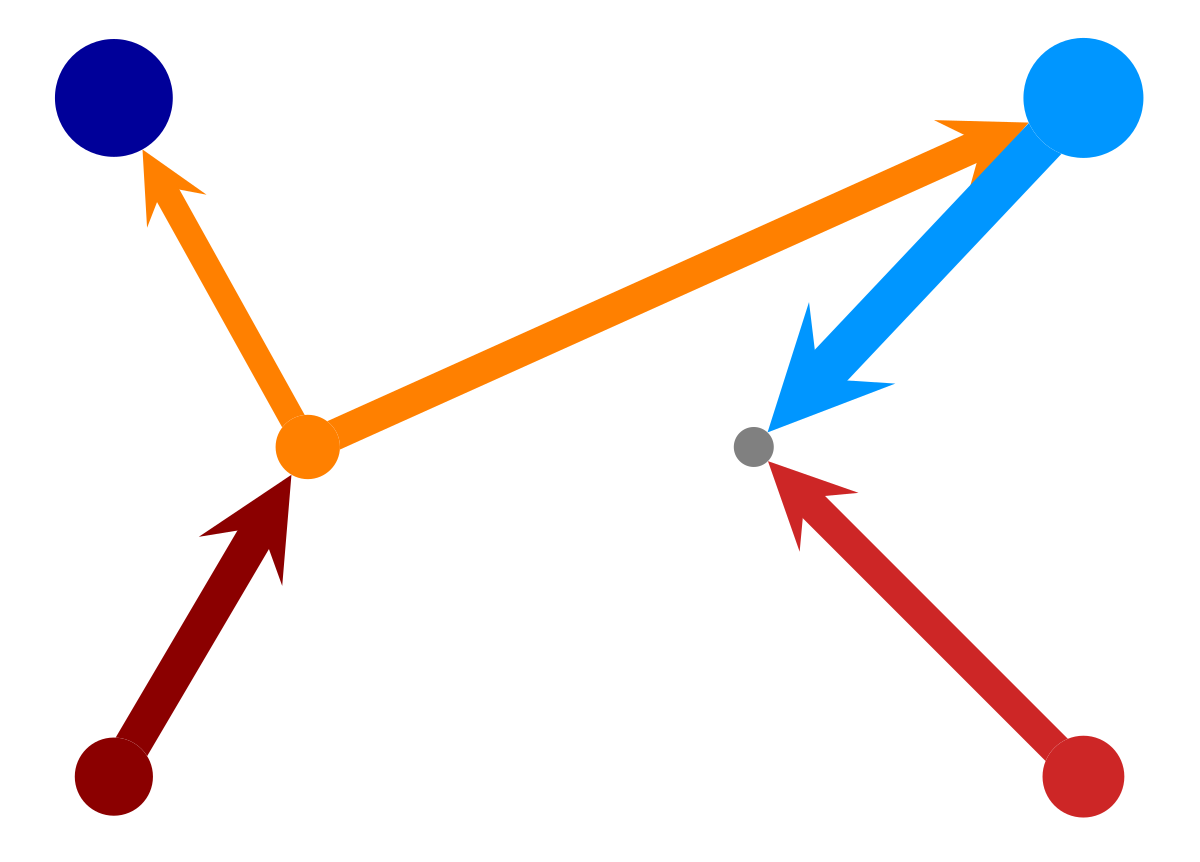

----------------------------------------------
fdhr_treshold =  0.001
p_value =  5
test =  pars_corr
pc_alpha =  0.01
group =  IandS
client =  OfficialClient
treshold causal =  0.2


          IandS        WT        WC        ST        SC         U
IandS  0.383552  0.024602  0.050696  0.286512  0.202773  0.055367
WT     0.176426  0.509885  0.118072  0.044063  0.179196  0.086597
WC     0.258658  0.048491  0.789938  0.154644  0.133372   0.04869
ST     0.112504  0.018488    0.0172  0.483541  0.177304  0.054899
SC     0.202557  0.024533  0.072809  0.145062  0.775255  0.056517
U      0.182928   0.24061  0.351869  0.066589  0.135833  0.207437
{'IandS': 0, 'WT': 1, 'WC': 2, 'ST': 3, 'SC': 4, 'U': 5}


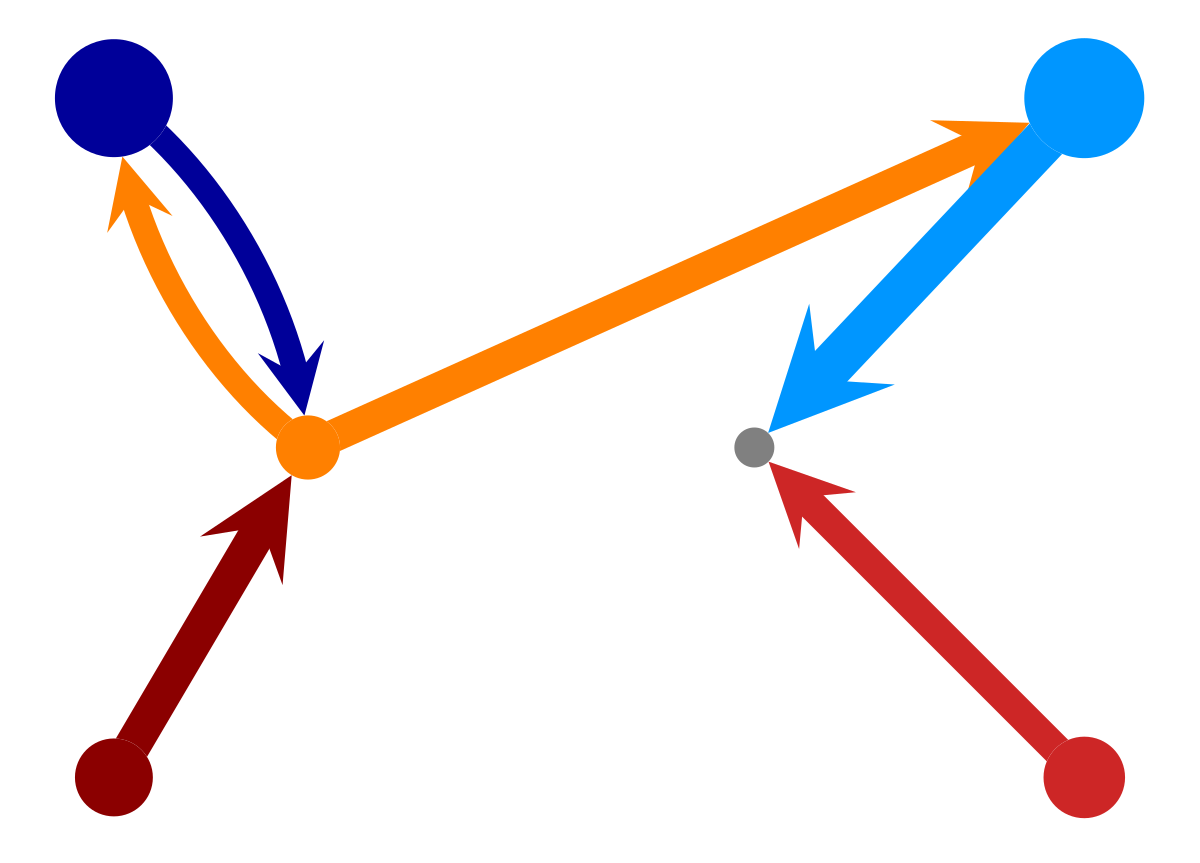

----------------------------------------------
fdhr_treshold =  0.001
p_value =  5
test =  pars_corr
pc_alpha =  0.001
group =  IandS
client =  OfficialClient
treshold causal =  0.2


          IandS        WT        WC        ST        SC         U
IandS  0.376609  0.048032  0.038569  0.268625  0.172647  0.026762
WT     0.226805  0.521008  0.082873  0.095437  0.190899  0.053964
WC     0.289041  0.060434  0.787729  0.188519  0.122513  0.067502
ST     0.046621  0.026497  0.018972  0.504056  0.154472  0.051826
SC     0.231991  0.021216  0.038735  0.203241  0.766119  0.039899
U      0.239469    0.2472  0.342455  0.096266  0.156116  0.202343
{'IandS': 0, 'WT': 1, 'WC': 2, 'ST': 3, 'SC': 4, 'U': 5}


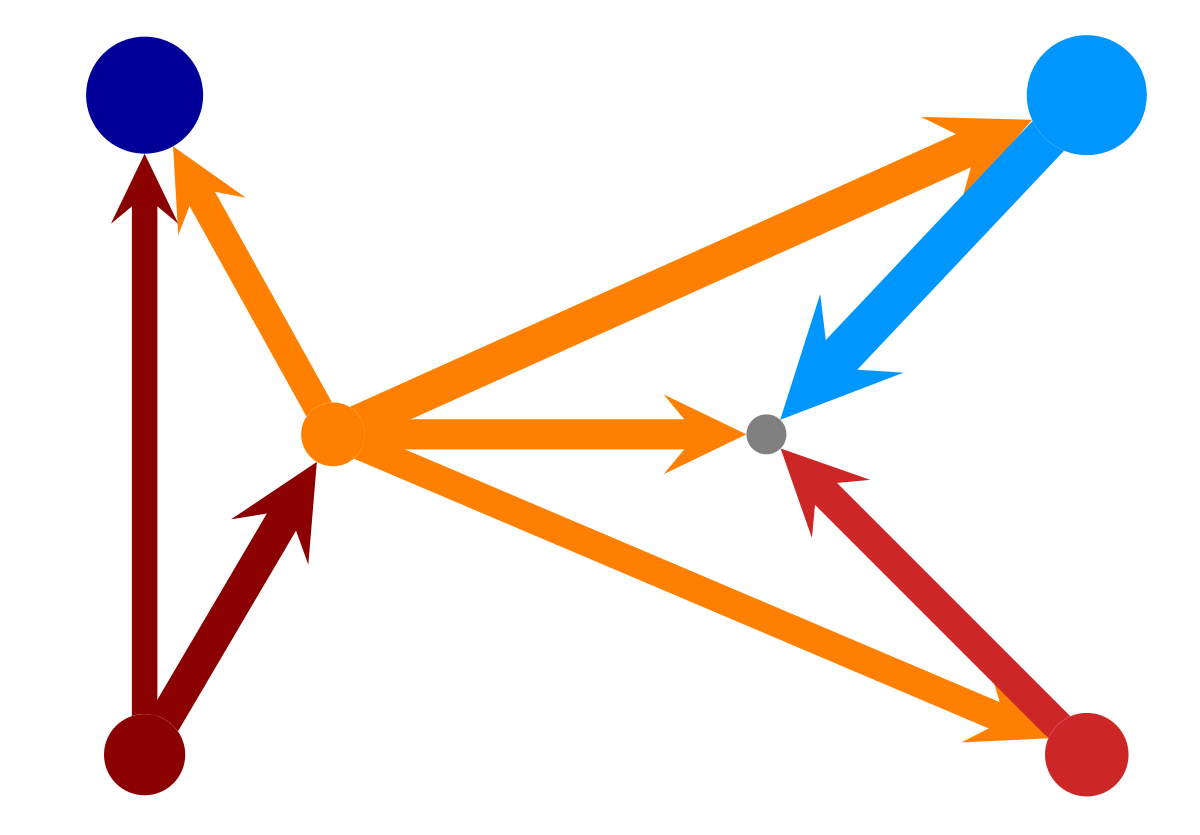

----------------------------------------------


In [143]:
clients = 'OfficialClient'
group = 'IandS'
p_val = '5'
fdhr = '0.001'

res = print_results(clients,group,p_val,fdhr,thresh = 0.2,path = 'causal2')

Text(0.5, 0, 'CEmax')

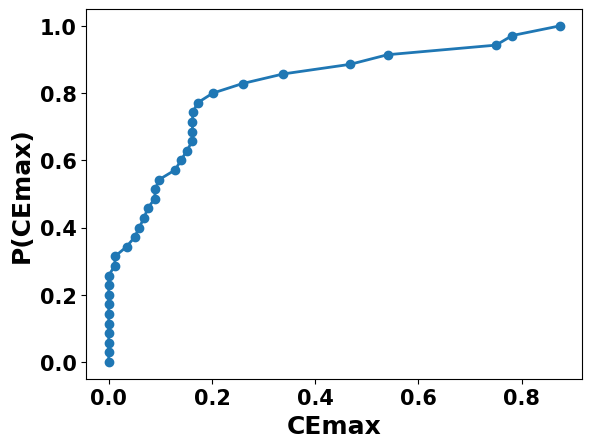

In [117]:
import matplotlib.pyplot as plt
res['df_CEmax'] = res['df_CEmax'].fillna(0)

data = np.concatenate(res['df_CEmax'].values)
# sort the data:
data_sorted = np.sort(data)

# calculate the proportional values of samples
p = 1. * np.arange(len(data)) / (len(data) - 1)

plt.plot(data_sorted,p,'o-',linewidth = 2)
plt.xticks(fontweight='bold',fontsize = 15)
plt.yticks(fontweight='bold',fontsize = 15)
plt.ylabel('P(CEmax)',fontweight='bold')
plt.xlabel('CEmax',fontweight='bold')

Text(0.5, 0, 'CEmax')

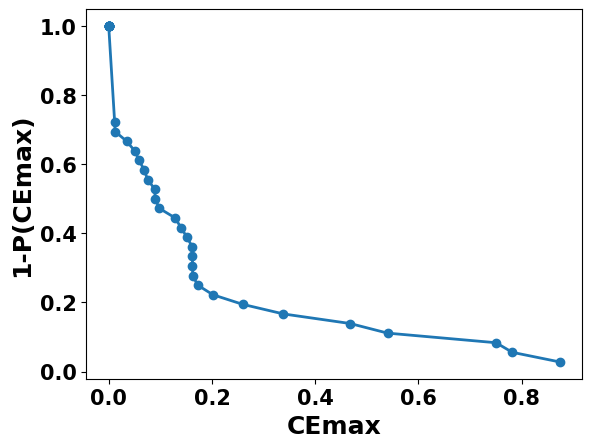

In [106]:
def compute_CCDF(data, normalize=True):
    x = np.sort(data)
    
    counts = x.size - np.searchsorted(x,x[::-1],side='left') 

    
    if normalize:
        counts = np.true_divide(counts, counts[-1])
        
    return x[::-1], counts
x,y=compute_CCDF(data, normalize=True)

plt.plot(x,y,'o-',linewidth = 2)
plt.xticks(fontweight='bold',fontsize = 15)
plt.yticks(fontweight='bold',fontsize = 15)
plt.ylabel('1-P(CEmax)',fontweight='bold')
plt.xlabel('CEmax',fontweight='bold')

In [131]:
sum(data[data>=0.1623])/sum(data)

0.75258339514362

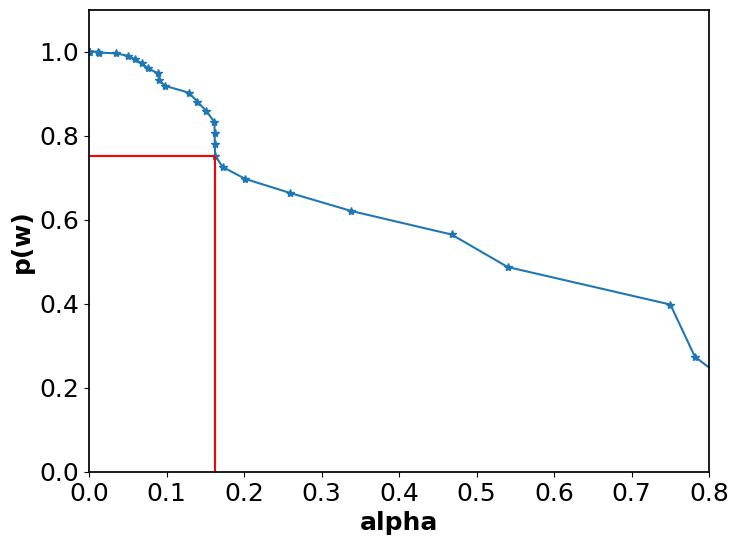

In [110]:
from matplotlib import rc,rcParams
font = {'size'   : 18}
rc('font', **font)

y = np.cumsum(sorted(data/sum(data),reverse=True))

fig, ax = plt.subplots(1,1,figsize=(8,6))

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25) 
    
plt.plot(x,y,'*-')
plt.vlines(x = 0.1623,ymin=0., ymax=y[x>=0.1623][-1],color='red')
plt.hlines(y = y[x>=0.1623][-1],xmin=0., xmax=0.1623,color='red')

plt.ylabel('p(w)',fontsize=18,fontweight='bold')
plt.xlabel('alpha',fontsize=18,fontweight='bold')

#plt.xticks(ax.xaxis.set_major_locator(plt.MaxNLocator(9)),rotation=90,fontweight='bold')

#plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1), shadow=True, ncol=2, prop={'size': 15.5})
#ax.tick_params( length=5, width=1, grid_alpha=0.7)
plt.ylim([0,1.1])
plt.xlim([0,0.8])

#plt.savefig('Figures/Fig8.pdf',bbox_inches='tight')

plt.show()

In [47]:
np.cumsum(sorted(data/sum(data),reverse=True))[13]

0.7432331286110244

In [118]:
table=res['df_CEmax']
table=table.astype(float).round(2) 

In [119]:
error=res['df_CEmax_std']
error=error.astype(float).round(3) 

In [125]:
error.values

array([[0.006,   nan,   nan,   nan,   nan,   nan],
       [  nan, 0.015, 0.024, 0.015, 0.022, 0.019],
       [  nan, 0.021, 0.014, 0.011, 0.02 , 0.02 ],
       [  nan, 0.004, 0.015, 0.011, 0.015, 0.003],
       [  nan, 0.018, 0.013, 0.012, 0.013, 0.01 ],
       [  nan, 0.017, 0.021, 0.015, 0.02 , 0.019]])

In [ ]:
array([[0.006,   nan,   nan,   nan,   nan,   nan],
       [  nan, 0.015, 0.024, 0.015, 0.022, 0.019],
       [  nan, 0.021, 0.014, 0.011, 0.02 , 0.02 ],
       [  nan, 0.004, 0.015, 0.011, 0.015, 0.003],
       [  nan, 0.018, 0.013, 0.012, 0.013, 0.01 ],
       [  nan, 0.017, 0.021, 0.015, 0.02 , 0.019]])

In [ ]:
\begin{table}[!h]
\resizebox{\textwidth}{!}{ \begin{tabular}{|l|r|r|r|r|r|l|}
      &     Ego          &        $W_T$ &        $W_C$ &        $S_T$ &    $S_C$ &    U \\\hline
Ego   &   0.87 \pm 0.006 &  0  &  0  &  0  & 0  & 0   \\
WT    &   0  &  0.54 \pm 0.0155 &  0.08 \pm 0.024 &  0.15 \pm0.015  & 0.16 \pm  0.022  &  0.05 \pm 0.019  \\
WC    &   0  &  0.1 \pm 0.021 &  0.78 \pm 0.014 &  0.16 \pm 0.011  &  0.13 \pm 0.02  &  0.09 \pm 0.02   \\
ST    &   0  &  0.01 \pm 0.004 &  0.03 \pm 0.015 &  0.47 \pm  0.011  &  0.17 \pm 0.015  &  0.01 \pm 0.003  \\
SC    &   0  &   0.06 \pm 0.018 &  0.09 \pm 0.013 &  0.16 \pm  0.012  &  0.75 \pm 0.013  &  0.07 \pm0.016  \\
U     &   0  &  0.26 \pm 0.017 & 0.34 \pm 0.021 &  0.16 \pm 0.015  &  0.14 \pm  0.02  &  0.2 \pm 0.019  \\
                          end{tabular}}
\caption{{\bf Causal Links.} We show the value of the maximal causal effect ICE,maxi→j=max0<τ≤τmax∣∣ICEi→j(τ)∣∣
 between each pair (i, j) of activity time series, where τmax = 18 × 15 min = 4.5 h is the maximal time lag considered, with standard errors (s.d., see Methods). The arrows indicate the direction of the causal effect. For each activity time series, we indicate in 
         bold the three most important drivers of activity (excluding themselves)}
\label{table:causal}
\end{table}

In [ ]:
\begin{table}[!h]
\resizebox{\textwidth}{!}{ \begin{tabular}{|l|r|r|r|r|r|l|}
      &     Ego &        $W_T$ &        $W_C$ &        $S_T$ &    $S_C$ &    U \\\hline
Ego   &   0.38 \pm 0.012 &  0.05 \pm 0.010 &  0.06 \pm 0.010 &  0.26 \pm 0.028  &  0.14 \pm 0.019  &  0.02 \pm 0.014  \\
WT    &   0.16 \pm 0.016 &  0.55 \pm 0.015 &  0.25 \pm 0.020 &  0.09 \pm 0.021  &  0.16 \pm 0.022  &  0.22 \pm 0.017  \\
WC    &   0.27 \pm 0.029 &  0.03 \pm 0.008 &  0.80 \pm 0.016 &  0.14 \pm 0.029  &  0.21 \pm 0.022  &  0.15 \pm 0.011  \\
ST    &   0.14 \pm 0.029 &  0.02 \pm 0.006 &  0.05 \pm 0.009 &  0.59 \pm 0.018  &  0.16 \pm 0.018  &  0.05 \pm 0.006  \\
SC    &   0.21 \pm 0.031 &  0.02 \pm 0.006 &  0.01 \pm 0.007 &  0.18 \pm 0.033  &  0.72 \pm 0.012  &  0.01 \pm 0.006  \\
U     &   0.20 \pm 0.019 &  0.26 \pm 0.012 &  0.37 \pm 0.016 &  0.10 \pm 0.020  &  0.18 \pm 0.019  &  0.13 \pm 0.008  \\
                          end{tabular}}
\caption{{\bf Causal Links.} We show the value of the maximal causal effect ICE,maxi→j=max0<τ≤τmax∣∣ICEi→j(τ)∣∣
 between each pair (i, j) of activity time series, where τmax = 18 × 15 min = 4.5 h is the maximal time lag considered, with standard errors (s.d., see Methods). The arrows indicate the direction of the causal effect. For each activity time series, we indicate in 
         bold the three most important drivers of activity (excluding themselves)}
\label{table:causal}
\end{table}

In [28]:
res = pd.read_pickle('/sdf/MatteoPaper/section_four/residuals2/UsersCat_15min_OfficialClient_IvsS_residuals_5_rp.pickle')


In [30]:
res.drop(columns='S')

,tot,IRA,WT,WC,ST,SC,U
datetime_EST,,,,,,,
2016-06-01 00:00:00,530.380563,-2.467264,-14.236360,-14.650115,424.581594,137.170280,-20.558762
2016-06-01 00:15:00,-823.212357,0.752869,-33.502301,-152.294065,-104.258409,-329.171041,-10.291711
2016-06-01 00:30:00,117.575453,-0.431861,-8.072999,-2.486484,90.936255,51.475944,6.896811
2016-06-01 00:45:00,-104.084811,-3.266182,-10.122946,-7.276341,-120.399659,24.504221,9.938603
2016-06-01 01:00:00,65.910839,-1.268686,-13.737966,-0.480807,47.418937,9.841153,-5.383305
...,...,...,...,...,...,...,...
2016-11-08 22:45:00,-153.361946,-7.283577,761.817480,-280.652055,71.948508,-480.025974,191.447856
2016-11-08 23:00:00,4158.701466,-4.988133,640.137095,110.241313,801.498783,176.970271,184.124403
2016-11-08 23:15:00,777.015142,-4.097586,240.946299,-594.018067,618.189368,180.992663,36.779385


In [98]:
res = pd.read_pickle('/sdf/MatteoPaper/section_four/residuals2/UsersCat_15min_OfficialClient_IandS_residuals_5_rp.pickle')
#import matplotlib.pyplot as plt

def print_residuals(residuals):       
    # print(tsts_resid)
    fig, ax1 = plt.subplots(figsize=(20, 6))
    color = 'tab:red'
    ax1.set_ylabel('Pro T (residuals)', color=color)  # we already handled the x-label with ax1
    # ax1.set_ylim((-600, 600))
    ax1.plot("WC", data=residuals, color=color, lw=1)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel("Pro H (residuals)", color=color)  # we already handled the x-label with ax1
    # ax2.set_ylim((-20000, 20000))
    ax2.plot("IandS", data=residuals, color=color, lw=1)
    ax2.tick_params(axis='y', labelcolor=color)
    #plt.savefig(f"fig/c{cN}-{layer}-layer-resid.pdf", dpi=300)
    plt.show()
    #plt.close()

In [ ]:
res['df_CEmax_std'].astype(float).round(2) 

In [97]:
res

,tot,IandS,WT,WC,ST,SC,U
datetime_EST,,,,,,,
2016-06-01 00:00:00,530.380563,79.420491,-14.236360,-14.650115,424.581594,137.170280,-20.558762
2016-06-01 00:15:00,-823.212357,-127.020084,-33.502301,-152.294065,-104.258409,-329.171041,-10.291711
2016-06-01 00:30:00,117.575453,1.235505,-8.072999,-2.486484,90.936255,51.475944,6.896811
2016-06-01 00:45:00,-104.084811,22.323648,-10.122946,-7.276341,-120.399659,24.504221,9.938603
2016-06-01 01:00:00,65.910839,40.768910,-13.737966,-0.480807,47.418937,9.841153,-5.383305
...,...,...,...,...,...,...,...
2016-11-08 22:45:00,-153.361946,-184.436380,761.817480,-280.652055,71.948508,-480.025974,191.447856
2016-11-08 23:00:00,4158.701466,306.392066,640.137095,110.241313,801.498783,176.970271,184.124403
2016-11-08 23:15:00,777.015142,557.298597,240.946299,-594.018067,618.189368,180.992663,36.779385


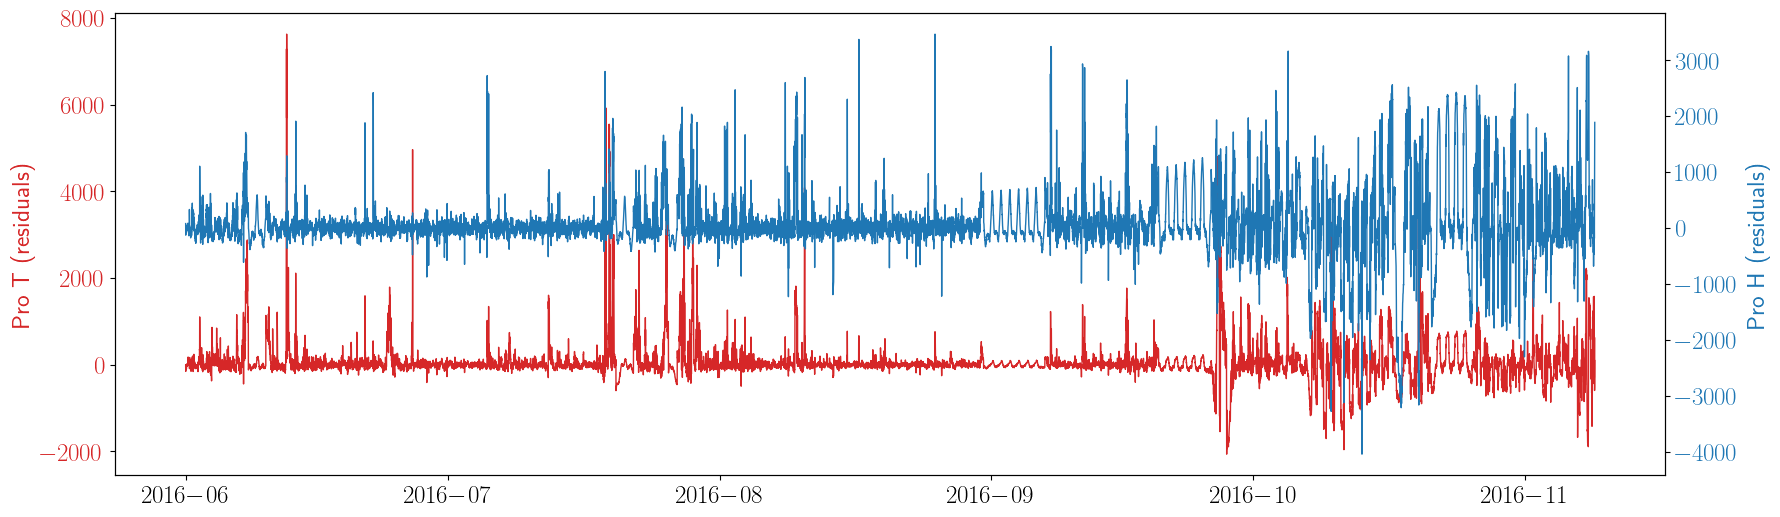

In [99]:
print_residuals(res)

In [ ]:
vsize = G.new_vertex_property('float')

# use autolinks for node size
for name in df_CEmax.columns:
    print(name,df_CEmax.loc[name,name])
    vsize[name2v_id[name]] = df_CEmax.loc[name,name]

max_vsize = 60
min_vsize = 20

vsize.a = (vsize.a - vsize.a.min())/(max((vsize.a - vsize.a.min())))*(max_vsize-min_vsize) +\
          min_vsize


In [ ]:
vsize.a

In [ ]:

for path in glob.glob('/home/matteo/IRA_paper/Final_codes_and_data/data/casual/*'):
    if 'UsersCat' not  in path:
        continue
    print(path)
    alg=path.split('/')[-1].split('_')[0]
    test=' '.join(path.split('/')[-1].split('_')[2:5])
    pcalpha=' '.join(path.split('/')[-1].split('_')[5:7])
    tau=' '.join(path.split('/')[-1].split('_')[7:9])
    infl=' '.join(path.split('/')[-1].split('_')[10:12])
    file=' '.join(path.split('/')[-1].split('_')[12:14])
    max_comb=' '.join(path.split('/')[-1].split('_')[14:16])
    dfr=' '.join(path.split('/')[-1].split('_')[16:18])
    
    print(alg)
    print(test)
    print(pcalpha)
    print(tau)
    print(infl)
    print(file)
    print(max_comb)
    print(dfr)
    
    res = pd.read_pickle(path)
    print(res['df_CEmax'])